In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
import joblib

import warnings 
warnings.filterwarnings('ignore')


In [6]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [7]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,19223,559,592,544375,544389,140,19,15,15524,103,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [8]:
df_train.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [9]:
info=df_train.info()
print(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [10]:
df_train.drop("id",axis=1,inplace=True)
des=df_train.describe()
des

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
corr = df_train.corr()
corr

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
X_Minimum,1.000000,0.989767,0.016071,0.014247,-0.464759,-0.451961,-0.426514,-0.430073,0.337748,-0.132955,...,0.276871,-0.068844,-0.376973,0.119306,-0.107581,-0.510597,0.046159,0.044439,0.205123,0.169608
X_Maximum,0.989767,1.000000,0.018909,0.016513,-0.391937,-0.378434,-0.356528,-0.363092,0.275571,-0.129669,...,0.237157,-0.079235,-0.319598,0.108808,-0.126807,-0.441177,0.036824,0.037949,0.186930,0.153448
Y_Minimum,0.016071,0.018909,1.000000,0.969552,-0.007370,-0.012712,-0.024876,-0.008189,-0.017321,-0.029160,...,-0.044202,-0.023000,-0.031511,-0.015512,-0.012143,0.010612,-0.039151,-0.005449,0.056442,-0.019227
Y_Maximum,0.014247,0.016513,0.969552,1.000000,-0.007019,-0.012377,-0.024798,-0.007809,-0.018739,-0.028312,...,-0.042490,-0.022869,-0.030345,-0.016287,-0.012899,0.011304,-0.040874,-0.007416,0.056610,-0.018533
Pixels_Areas,-0.464759,-0.391937,-0.007370,-0.007019,1.000000,0.835079,0.834543,0.797843,-0.622867,0.130499,...,-0.269013,-0.015081,0.542672,-0.101295,-0.081567,0.701014,-0.077470,-0.053548,-0.224037,-0.195931
X_Perimeter,-0.451961,-0.378434,-0.012712,-0.012377,0.835079,1.000000,0.912579,0.802072,-0.603891,0.158036,...,-0.234969,0.005212,0.561256,-0.104322,-0.070433,0.675056,-0.084615,-0.050186,-0.218289,-0.186234
Y_Perimeter,-0.426514,-0.356528,-0.024876,-0.024798,0.834543,0.912579,1.000000,0.809171,-0.602826,0.160831,...,-0.113968,-0.005650,0.608167,-0.064965,-0.062092,0.630270,-0.100204,-0.019334,-0.227256,-0.174581
Sum_of_Luminosity,-0.430073,-0.363092,-0.008189,-0.007809,0.797843,0.802072,0.809171,1.000000,-0.580857,0.128569,...,-0.234625,-0.013845,0.520282,-0.093160,-0.059598,0.640597,-0.074245,-0.046712,-0.207316,-0.184651
Minimum_of_Luminosity,0.337748,0.275571,-0.017321,-0.018739,-0.622867,-0.603891,-0.602826,-0.580857,1.000000,0.397265,...,0.179385,0.619174,-0.504692,-0.004622,0.061146,-0.586957,0.166976,0.077386,0.134339,0.208857
Maximum_of_Luminosity,-0.132955,-0.129669,-0.029160,-0.028312,0.130499,0.158036,0.160831,0.128569,0.397265,1.000000,...,-0.113531,0.853856,0.018501,-0.086090,-0.076961,0.121755,0.115789,0.020471,-0.069808,-0.008368


<Axes: >

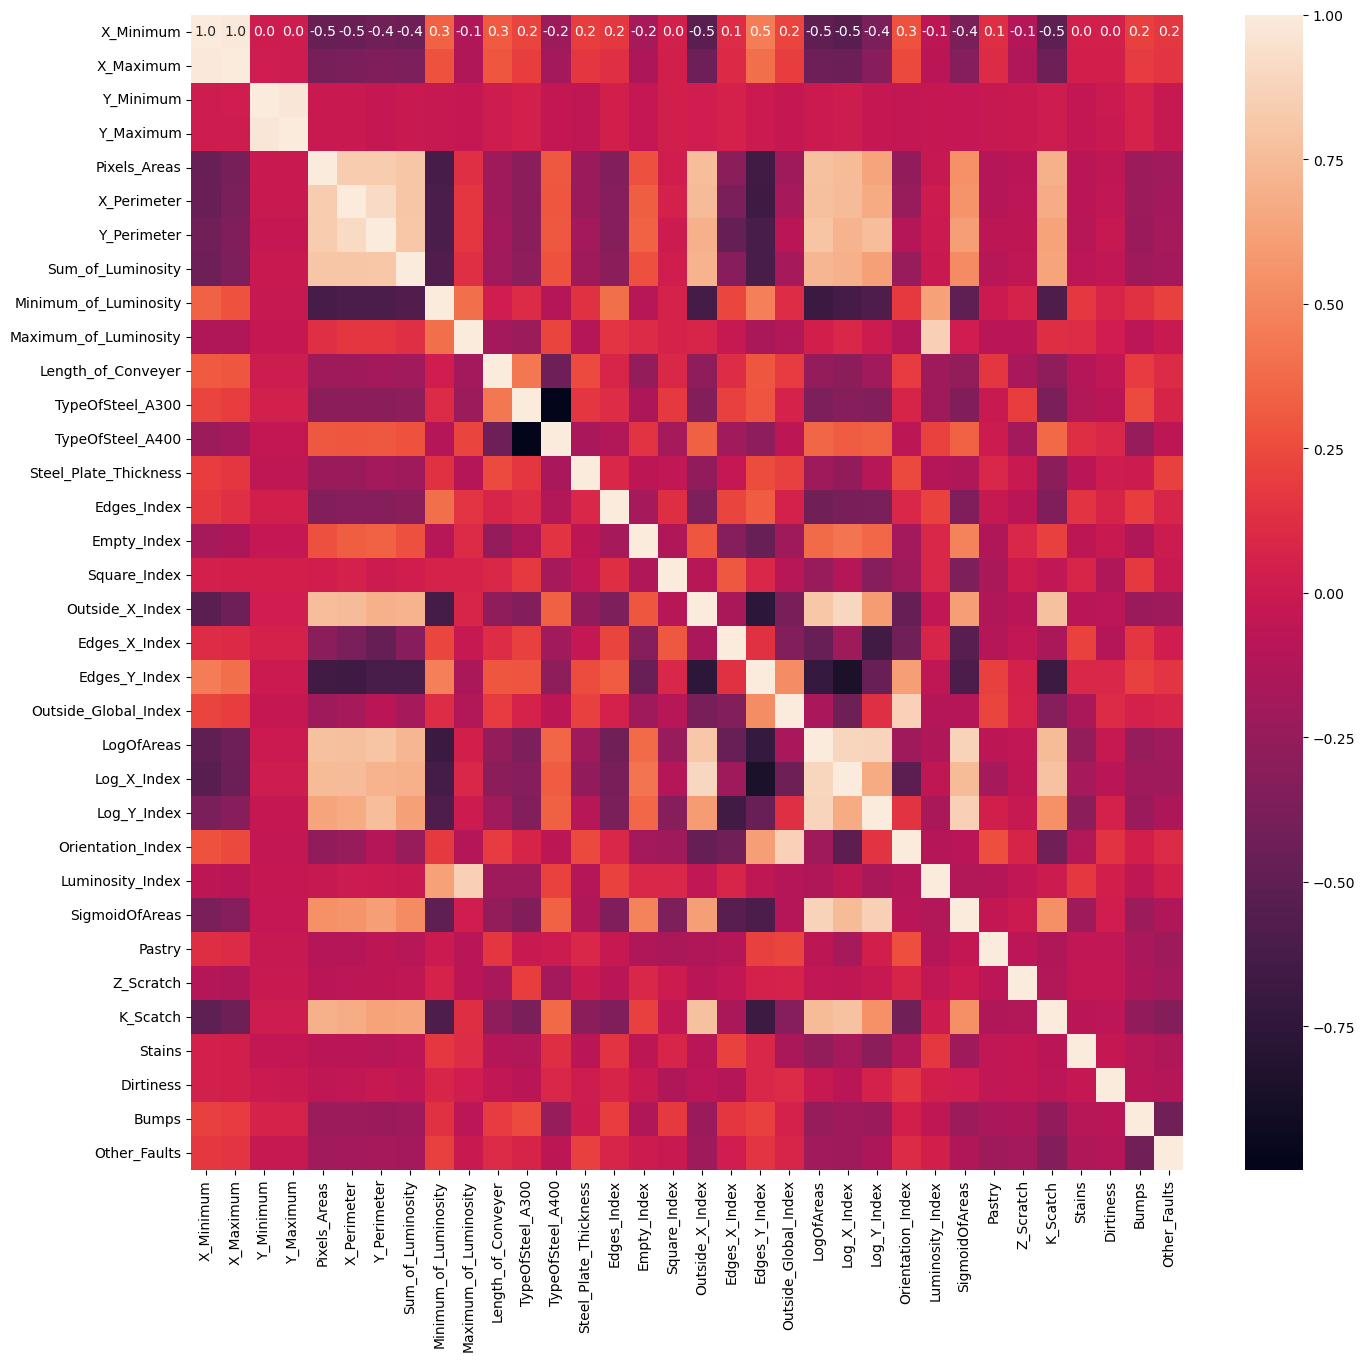

In [12]:
plt.figure(figsize=(16,15))
sns.heatmap(corr, annot=True,fmt=".1f")

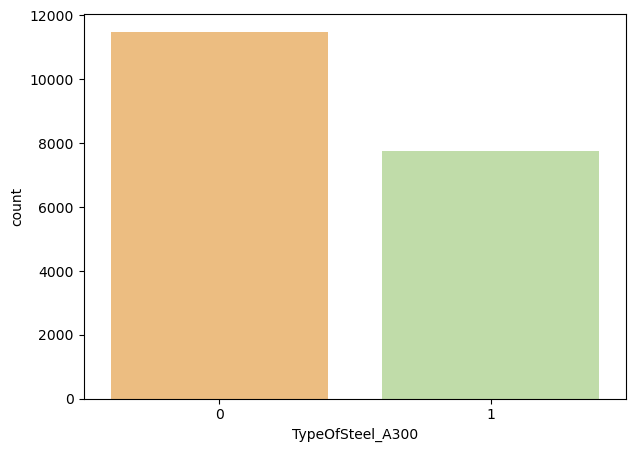

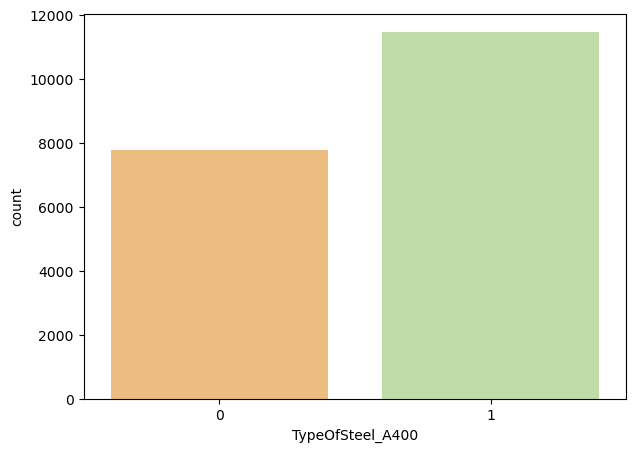

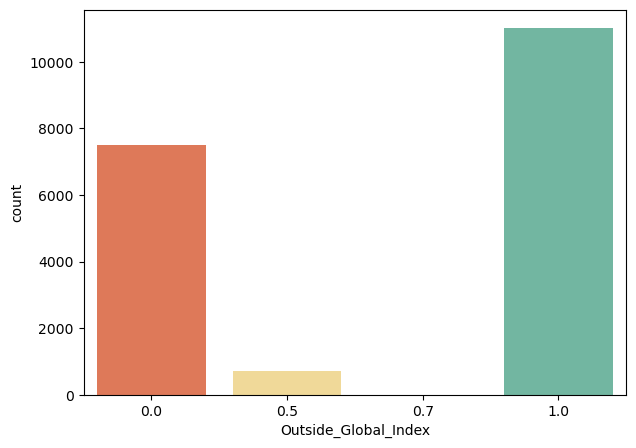

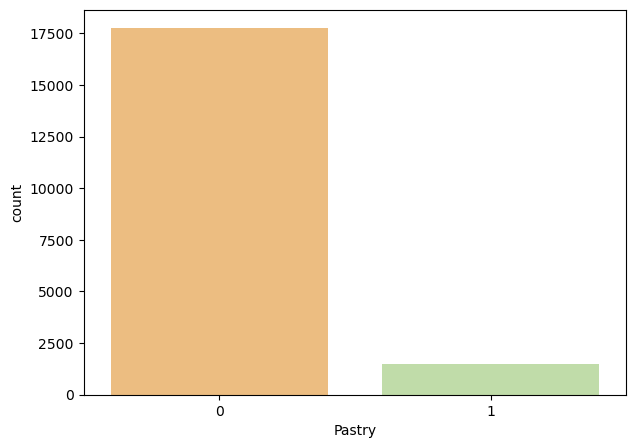

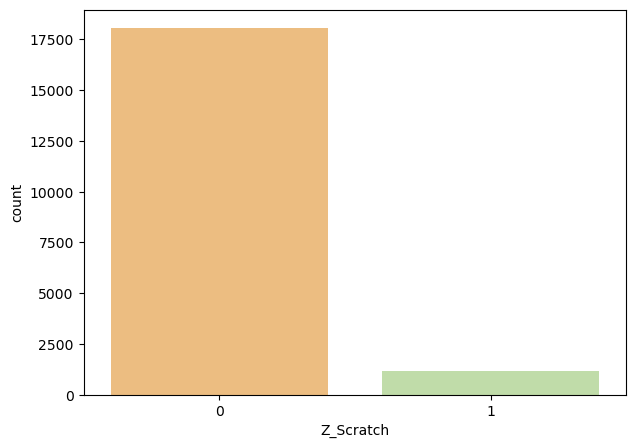

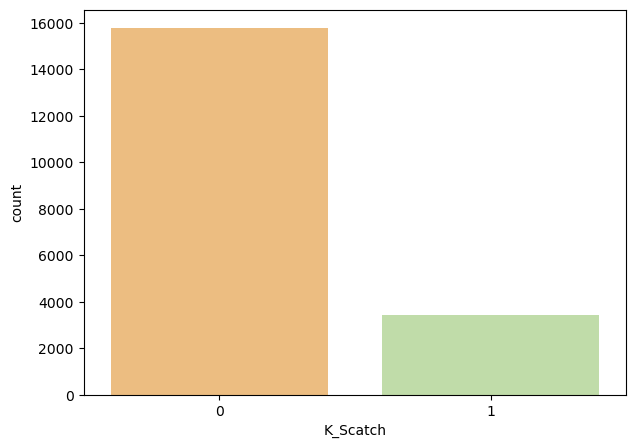

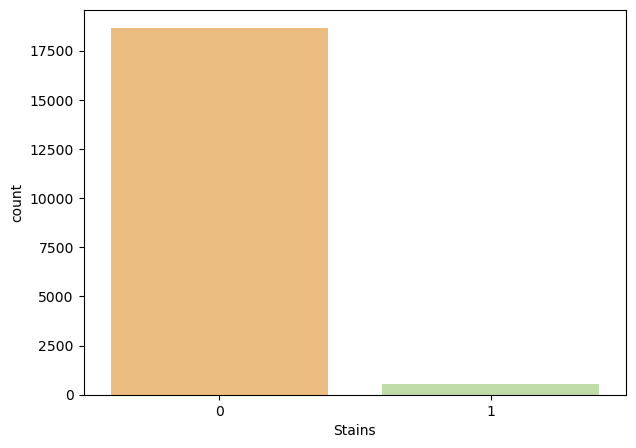

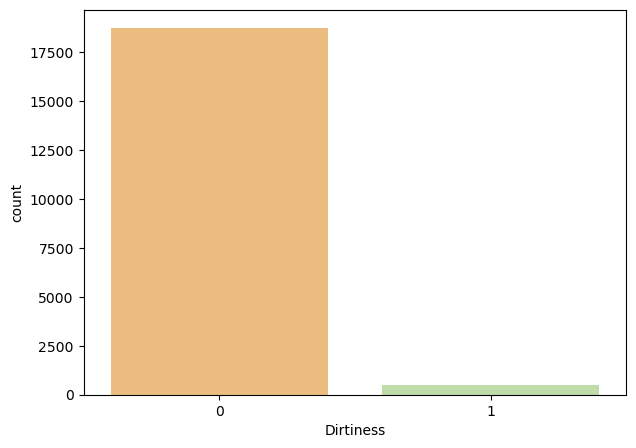

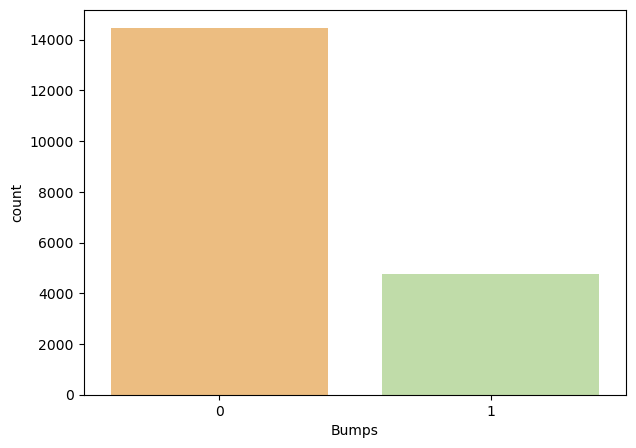

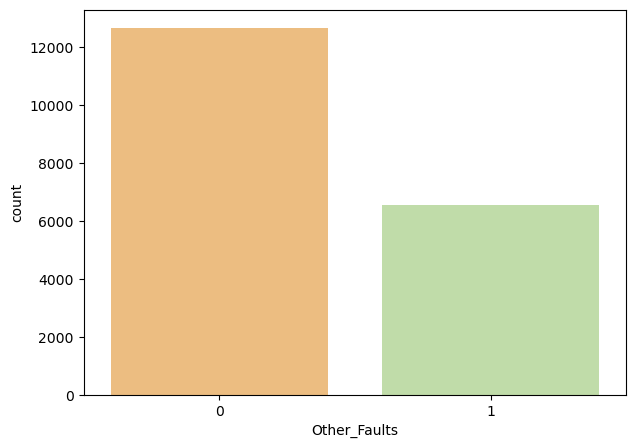

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
for i  in df_train.nunique()[df_train.nunique()<10].index:
    plt.figure(figsize=[7,5])
    sns.countplot(df_train, x=df_train[i],palette='Spectral')
plt.show()

In [14]:
X_train = df_train.iloc[:,:-7]
X_train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [15]:
X_test = df_test.iloc[:,:-7]
X_test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,1656,0,1,150,0.3877,0.4896,0.3273,0.0095,0.5652,1.0000
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,1354,0,1,40,0.1629,0.4136,0.0938,0.0047,0.2414,1.0000
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,1360,0,1,40,0.0609,0.6234,0.4762,0.0155,0.6000,0.7500
3,19222,158,168,232415,232440,80,10,11,8586,107,...,1690,1,0,100,0.4439,0.3333,0.8182,0.0037,0.8000,1.0000
4,19223,559,592,544375,544389,140,19,15,15524,103,...,1688,1,0,60,0.8191,0.2619,0.4286,0.0158,0.8421,0.5333


In [16]:
Y_train = df_train.iloc[:,-7:]
Y_train

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
19214,0,0,0,1,0,0,0
19215,0,0,0,0,0,0,1
19216,1,0,0,0,0,0,0
19217,0,0,0,0,0,0,1


In [17]:
Y_test = df_test.iloc[:,-7:]
Y_test

,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170
...,...,...,...,...,...,...,...
12809,1.0,2.4955,1.2305,1.6335,0.7661,-0.3109,0.8894
12810,1.0,1.7708,0.8451,1.2553,0.7222,-0.0448,0.1954
12811,0.0,4.2525,2.2504,2.2672,-0.0629,-0.0801,1.0000
12812,1.0,2.5866,1.1139,1.5911,0.8461,-0.2629,0.7844


In [18]:
Y_train.value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      1               6540
                                                1      0               4761
                   1         0       0          0      0               3411
1       0          0         0       0          0      0               1465
0       1          0         0       0          0      0               1150
        0          0         0       0          0      0                818
                             1       0          0      0                568
                             0       1          0      0                485
                   1         0       0          0      1                 18
                                                1      0                  2
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [19]:
rf_classifier = RandomForestClassifier()
extra_trees_cl = ExtraTreesClassifier()
xgb_classifier = XGBClassifier()
cat_boost = CatBoostClassifier()
lgbm_classifier = LGBMClassifier()

In [20]:
Y_train.columns

Index(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps',
       'Other_Faults'],
      dtype='object')

In [23]:
rf_models = []
extratree_models = []
xgb_models = []
lgbm_models = []
catboost_models = []

for i in Y_train.columns:
    rf_model = RandomForestClassifier(random_state = 100, n_estimators = 150)
    rf_model.fit(X_train,Y_train[i])
    rf_models.append(rf_model)
    rf_mean_score = cross_val_score(rf_model, X_train, Y_train[i], cv=5, scoring='accuracy').mean()
    print(f"\nRandomForest Model for {i}, Area under the ROC Curve = ", rf_mean_score)

    extratree_model = ExtraTreesClassifier(random_state = 100, n_estimators = 150)
    extratree_model.fit(X_train,Y_train[i])
    extratree_models.append(extratree_model)
    extratree_mean_score = cross_val_score(extratree_model, X_train, Y_train[i], cv=5, scoring='accuracy').mean()
    print(f"ExtraTree Model for {i}, Area under the ROC Curve =", extratree_mean_score)

    
    xgb_model = XGBClassifier(random_state=70, n_estimators = 200, learning_rate = 0.001)
    xgb_model.fit(X_train, Y_train[i])
    xgb_models.append(xgb_model)
    xgb_mean_score = cross_val_score(xgb_model, X_train, Y_train[i], cv=5, scoring='accuracy').mean()
    print(f"XGB Model for {i}, Area under the ROC Curve = ", xgb_mean_score)

    lgbm_model = LGBMClassifier(random_state=70, verbose=-1, n_estimators = 200, learning_rate = 0.03)
    lgbm_model.fit(X_train, Y_train[i])
    lgbm_models.append(lgbm_model)
    lgbm_mean_score = cross_val_score(lgbm_model, X_train, Y_train[i], cv=5, scoring='accuracy').mean()
    print(f"LGBM Model for {i}, Area under the ROC Curve = ", lgbm_mean_score)

    catboost_model = CatBoostClassifier(random_state=100, verbose=0, iterations = 150, learning_rate = 0.01)
    catboost_model.fit(X_train, Y_train[i])
    catboost_models.append(catboost_model)
    catboost_mean_score = cross_val_score(catboost_model, X_train, Y_train[i], cv=5, scoring='accuracy').mean()
    print(f"CatBoost Model for {i}, Area under the ROC Curve = ", catboost_mean_score)

    


RandomForest Model for Pastry, Area under the ROC Curve =  0.9237733078481274
ExtraTree Model for Pastry, Area under the ROC Curve = 0.9241375659570504
XGB Model for Pastry, Area under the ROC Curve =  0.9237213193278426
LGBM Model for Pastry, Area under the ROC Curve =  0.9230449405557304
CatBoost Model for Pastry, Area under the ROC Curve =  0.9237213193278426

RandomForest Model for Z_Scratch, Area under the ROC Curve =  0.9547324581390871
ExtraTree Model for Z_Scratch, Area under the ROC Curve = 0.9520266451997402
XGB Model for Z_Scratch, Area under the ROC Curve =  0.940163379340466
LGBM Model for Z_Scratch, Area under the ROC Curve =  0.954940534068321
CatBoost Model for Z_Scratch, Area under the ROC Curve =  0.9529633456562372

RandomForest Model for K_Scatch, Area under the ROC Curve =  0.9621208527308731
ExtraTree Model for K_Scatch, Area under the ROC Curve = 0.9620167673808862
XGB Model for K_Scatch, Area under the ROC Curve =  0.8214267166298008
LGBM Model for K_Scatch, Ar

In [24]:
best_model = max([
    (rf_mean_score, 'Random Forest'),
    (lgbm_mean_score, 'LightGBM'),
    (xgb_mean_score, 'XGBoost'),
    (catboost_mean_score, 'CatBoost'),
    (extratree_mean_score, 'ExtraTrees'),
])

print("Best Model:", best_model[1])

Best Model: LightGBM


In [25]:
# Multioutputclassifier simplifies the training process

rf_multi_classifier = MultiOutputClassifier(rf_classifier, 
                                            n_jobs=-1)
lgbm_multi_classifier = MultiOutputClassifier(lgbm_classifier, 
                                              n_jobs=-1)
xgb_multi_classifier = MultiOutputClassifier(xgb_classifier, 
                                             n_jobs=-1)
catboost_multi_classifier = MultiOutputClassifier(cat_boost, 
                                                  n_jobs=-1)
extratrees_multi_classifier = MultiOutputClassifier(extra_trees_cl, 
                                                    n_jobs=-1)


In [26]:
best_classifier = None
if best_model[1] == 'Random Forest':
    best_classifier = rf_multi_classifier.fit(X_train, Y_train)
elif best_model[1] == 'LightGBM':
    best_classifier = lgbm_multi_classifier.fit(X_train, Y_train)
elif best_model[1] == 'XGBoost':
    best_classifier = xgb_multi_classifier.fit(X_train, Y_train)
elif best_model[1] == 'CatBoost':
    best_classifier = catboost_multi_classifier.fit(X_train, Y_train)
elif best_model[1] == 'ExtraTrees':
    best_classifier = extratrees_multi_classifier.fit(X_train, Y_train)
elif best_model[1] == 'GradientBoosting':     
    best_classifier = GradientBoosting_multi_Classifier.fit(X_train, Y_train)

In [27]:
model = joblib.dump(best_classifier, 'best_model.joblib')

In [34]:
df_test_id = df_test['id']
test_features=df_test.drop("id",axis=1)

In [35]:
best_test_probs = best_classifier.predict_proba(test_features)
best_test_probs

[array([[4.35544841e-01, 5.64455159e-01],
        [5.97485554e-01, 4.02514446e-01],
        [9.98563310e-01, 1.43669040e-03],
        ...,
        [9.99798737e-01, 2.01263386e-04],
        [6.62063522e-01, 3.37936478e-01],
        [9.99535064e-01, 4.64936472e-04]]),
 array([[9.99395972e-01, 6.04028274e-04],
        [9.95248355e-01, 4.75164459e-03],
        [9.70362127e-01, 2.96378727e-02],
        ...,
        [9.99873851e-01, 1.26149465e-04],
        [9.95819097e-01, 4.18090350e-03],
        [9.98707394e-01, 1.29260584e-03]]),
 array([[0.99753496, 0.00246504],
        [0.99659786, 0.00340214],
        [0.97163057, 0.02836943],
        ...,
        [0.02609582, 0.97390418],
        [0.99017065, 0.00982935],
        [0.075726  , 0.924274  ]]),
 array([[9.99997197e-01, 2.80311202e-06],
        [9.99993179e-01, 6.82086370e-06],
        [9.99774085e-01, 2.25914594e-04],
        ...,
        [9.99995666e-01, 4.33392358e-06],
        [9.99996769e-01, 3.23096727e-06],
        [9.99995715e-01,

In [36]:
submission = pd.DataFrame({'id': df_test_id})
# Iterate over each target
for i, target in enumerate(Y_train.columns):
    # Fetch the probability of the positive class for each target
    # Store the positive probabilities in the respective target column
    submission[target] = best_test_probs[i][:, 1]  # Probability of positive class

submission.to_csv('submission.csv', index=False)
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.564455,0.000604,0.002465,0.000003,0.015020,0.158640,0.333320
1,19220,0.402514,0.004752,0.003402,0.000007,0.275005,0.192562,0.292125
2,19221,0.001437,0.029638,0.028369,0.000226,0.001549,0.331755,0.441811
3,19222,0.232220,0.000447,0.000156,0.000028,0.004836,0.344696,0.457847
4,19223,0.001071,0.000496,0.000186,0.000123,0.003144,0.574299,0.382310
